In [161]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras import backend as K
import matplotlib.pyplot as plt
import math
import statistics
from sklearn.preprocessing import StandardScaler
import keras_tuner
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import TimeDistributed

In [162]:
#Define MSE function
def mse(y_true,y_pred):
    num =sum(( y_true-y_pred)**2)
    den=len(y_true)
    return num/den

In [163]:
#Define RMSE function
def rmse(y_true, y_pred):
    """ Root Mean Squared Error """
    return np.sqrt(mse(y_true, y_pred))

In [164]:
#plot loss function over epochs
def plotEpochloss(cnnhist):
    plt.plot(cnnhist['loss'])
    plt.plot(cnnhist['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [165]:
#function to format the data into window sequences
def preparedata(df, inputcols, outputcol, n_steps_in, n_steps_out):
    sequence = np.array(df[inputcols].sum(axis=1))
    X, y = list(), list()
    for i in range(len(sequence)):
        # determine pattern ending
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # break if past the end of the pattern
        if out_end_ix > len(sequence):
            break
        # break if past the end of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
        X_train = np.array(X)
        Y_train = np.array(y)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    return X_train, Y_train


In [166]:
#set up model and hyperparameters to be tuned
def GRU_modeler(hp):

    #tuning parameters
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_gru2=hp.Choice('hp_gru2', values=[0,1])
    hp_gru3=hp.Choice('hp_gru3', values=[0,1])
    hp_dropout=hp.Choice('dropout', values=[0.1,0.3,0.5])
    hp_dropout_block=hp.Choice('dropout_blocks', values=[0,1])
    hp_unitsl1 = hp.Choice('hp_unitsl1', values=[2, 4, 8, 32, 64, 128, 256])
    hp_unitsl2 = hp.Choice('hp_unitsl2', values=[2, 4, 8, 32, 64, 128, 256])
    hp_unitsl3 = hp.Choice('hp_unitsl3', values=[2, 4, 8, 32, 64, 128, 256])
    hp_gru2=hp.Choice('hp_gru2', values=[0,1])
    hp_gru3=hp.Choice('hp_gru3', values=[0,1])
    hp_activationl1=hp.Choice('activationsl1_', values=[0,1,2,3])
    hp_activationl2=hp.Choice('activationsl2_', values=[0,1,2,3])
    hp_activationl3=hp.Choice('activationsl3_', values=[0,1,2,3])


    model = Sequential()
    #GRU Layer 1
    if(hp_gru2==0 and hp_gru3==0):
        model.add(GRU(hp_unitsl1, input_shape=(num_steps_in, 1)))
    else:
        model.add(GRU(hp_unitsl1, input_shape=(num_steps_in, 1),return_sequences=True))

    #Activation is relu or nothing
    if (hp_activationl1==1): 
        model.add(Activation('relu'))
    elif (hp_activationl1==2): 
        model.add(Activation('tanh'))
    elif (hp_activationl1==3): 
        model.add(Activation('sigmoid'))

    #GRU Layer 2
    if(hp_gru2==1):
        if(hp_gru3==0):
            model.add(GRU(hp_unitsl2))
        else:
            model.add(GRU(hp_unitsl2, return_sequences=True))

        #Activation is relu or nothing
        if (hp_activationl2==1): 
            model.add(Activation('relu'))
        elif (hp_activationl2==2): 
            model.add(Activation('tanh'))
        elif (hp_activationl2==3): 
            model.add(Activation('sigmoid'))

    #LSTM Layer 3
    if(hp_gru3==1):
        model.add(GRU(hp_unitsl3))

        #Activation is relu or nothing
        if (hp_activationl3==1): 
            model.add(Activation('relu'))
        elif (hp_activationl3==2): 
            model.add(Activation('tanh'))
        elif (hp_activationl3==3): 
            model.add(Activation('sigmoid'))

    #0 or 1 Dropout layer
    if(hp_dropout_block==1):
        model.add(Dropout(hp_dropout))

    model.add(Dense(num_steps_out))
    Callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

    model.compile(keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mean_squared_error', metrics=['accuracy'])
    return model

In [167]:
#set up model and hyperparameters to be tuned
def LSTM_modeler(hp):

    #tuning parameters
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_lstm2=hp.Choice('hp_lstm2', values=[0,1])
    hp_lstm3=hp.Choice('hp_lstm3', values=[0,1])
    hp_dropout=hp.Choice('dropout', values=[0.1,0.3,0.5])
    hp_dropout_block=hp.Choice('dropout_blocks', values=[0,1])
    hp_unitsl1 = hp.Choice('hp_unitsl1', values=[2, 4, 8, 32, 64, 128, 256])
    hp_unitsl2 = hp.Choice('hp_unitsl2', values=[2, 4, 8, 32, 64, 128, 256])
    hp_unitsl3 = hp.Choice('hp_unitsl3', values=[2, 4, 8, 32, 64, 128, 256])
    hp_lstm2=hp.Choice('hp_lstm2', values=[0,1])
    hp_lstm3=hp.Choice('hp_lstm3', values=[0,1])
    hp_activationl1=hp.Choice('activationsl1_', values=[0,1,2,3])
    hp_activationl2=hp.Choice('activationsl2_', values=[0,1,2,3])
    hp_activationl3=hp.Choice('activationsl3_', values=[0,1,2,3])


    model = Sequential()
    #LSTM Layer 1
    if(hp_lstm2==0 and hp_lstm3==0):
        model.add(LSTM(hp_unitsl1, input_shape=(num_steps_in, 1)))
    else:
        model.add(LSTM(hp_unitsl1, input_shape=(num_steps_in, 1),return_sequences=True))

    #Activation is relu or nothing
    if (hp_activationl1==1): 
        model.add(Activation('relu'))
    elif (hp_activationl1==2): 
        model.add(Activation('tanh'))
    elif (hp_activationl1==3): 
        model.add(Activation('sigmoid'))

    #LSTM Layer 2
    if(hp_lstm2==1):
        if(hp_lstm3==0):
            model.add(LSTM(hp_unitsl2))
        else:
            model.add(LSTM(hp_unitsl2, return_sequences=True))

        #Activation is relu or nothing
        if (hp_activationl2==1): 
            model.add(Activation('relu'))
        elif (hp_activationl2==2): 
            model.add(Activation('tanh'))
        elif (hp_activationl2==3): 
            model.add(Activation('sigmoid'))

    #LSTM Layer 3
    if(hp_lstm3==1):
        model.add(LSTM(hp_unitsl3))

        #Activation is relu or nothing
        if (hp_activationl3==1): 
            model.add(Activation('relu'))
        elif (hp_activationl3==2): 
            model.add(Activation('tanh'))
        elif (hp_activationl3==3): 
            model.add(Activation('sigmoid'))

    #0 or 1 Dropout layer
    if(hp_dropout_block==1):
        model.add(Dropout(hp_dropout))

    model.add(Dense(num_steps_out))
    Callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

    model.compile(keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mean_squared_error', metrics=['accuracy'])
    return model

In [168]:
#set up model and hyperparameters to be tuned
def CNN_modeler(hp):

    #tuning parameters
    hp_filters1=hp.Choice('filters1_', values=[2,4,8,16,32,64,128,256])
    hp_kernels1=hp.Choice('kernels1_', values=[1,3,5,7,9,11,13,15])
    hp_filters2=hp.Choice('filters2_', values=[2,4,8,16,32,64,128,256])
    hp_kernels2=hp.Choice('kernels2_', values=[1,3,5,7,9,11,13,15])
    hp_filters3=hp.Choice('filters3_', values=[2,4,8,16,32,64,128,256])
    hp_kernels3=hp.Choice('kernels3_', values=[1,3,5,7,9,11,13,15])
    hp_filters4=hp.Choice('filters4_', values=[2,4,8,16,32,64,128,256])
    hp_kernels4=hp.Choice('kernels4_', values=[1,3,5,7,9,11,13,15])
    hp_filters5=hp.Choice('filters5_', values=[2,4,8,16,32,64,128,256])
    hp_kernels5=hp.Choice('kernels5_', values=[1,3,5,7,9,11,13,15])
    hp_units1=hp.Choice('units1', values=[25,50,75,100])
    hp_units2=hp.Choice('units2', values=[25,50,75,100])
    hp_units3=hp.Choice('units3', values=[25,50,75,100])
    hp_units4=hp.Choice('units4', values=[25,50,75,100])
    hp_units5=hp.Choice('units5', values=[25,50,75,100])
    hp_pool1=hp.Choice('pool_size1', values=[1,2,3,4])
    hp_pool2=hp.Choice('pool_size2', values=[1,2,3,4])
    hp_pool3=hp.Choice('pool_size3', values=[1,2,3,4])
    hp_pool4=hp.Choice('pool_size4', values=[1,2,3,4])
    hp_pool5=hp.Choice('pool_size5', values=[1,2,3,4])
    hp_dropout=hp.Choice('dropout', values=[0.1,0.3,0.5])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_Activations1=hp.Choice('activations1_', values=[0,1])
    hp_Activations2=hp.Choice('activations2_', values=[0,1])
    hp_Activations3=hp.Choice('activations3_', values=[0,1])
    hp_Activations4=hp.Choice('activations4_', values=[0,1])
    hp_Activations5=hp.Choice('activations5_', values=[0,1])
    hp_Activations6=hp.Choice('activations6_', values=[0,1])
    hp_Activations7=hp.Choice('activations7_', values=[0,1])
    hp_Activations8=hp.Choice('activations8_', values=[0,1])
    hp_Activations9=hp.Choice('activations9_', values=[0,1])
    hp_Activations10=hp.Choice('activations10_', values=[0,1])
    hp_conv_block2=hp.Choice('conv_blocks2', values=[0,1])
    hp_conv_block3=hp.Choice('conv_blocks3', values=[0,1])
    hp_conv_block4=hp.Choice('conv_blocks4', values=[0,1])
    hp_conv_block5=hp.Choice('conv_blocks5', values=[0,1])
    hp_dense_block1=hp.Choice('dense_blocks1', values=[0,1])
    hp_dense_block2=hp.Choice('dense_blocks2', values=[0,1])
    hp_dense_block3=hp.Choice('dense_blocks3', values=[0,1])
    hp_dense_block4=hp.Choice('dense_blocks4', values=[0,1])
    hp_dense_block5=hp.Choice('dense_blocks5', values=[0,1])
    hp_dropout_block=hp.Choice('dropout_blocks5', values=[0,1])
    hp_pooling_block1=hp.Choice('pooling_blocks1', values=[0,1])
    hp_pooling_block2=hp.Choice('pooling_blocks2', values=[0,1])
    hp_pooling_block3=hp.Choice('pooling_blocks3', values=[0,1])
    hp_pooling_block4=hp.Choice('pooling_blocks4', values=[0,1])
    hp_pooling_block5=hp.Choice('pooling_blocks5', values=[0,1])



    # define model
    model = Sequential()

    #Block 1 Conv
    #Always has 1 convolutional layer
    model.add(Conv1D(filters=hp_filters1, kernel_size=hp_kernels1, input_shape=(num_steps_in, 1)))

    #Activation is relu or nothing
    if( hp_Activations1==1):
        model.add(Activation('relu'))

    #0 or 1 pooling layers for each conv layer
        if( hp_pooling_block1==1):
            model.add(MaxPooling1D(pool_size=hp_pool1))

    #Block 2 Conv
    #iteration of additional conv layers between 0 and 1
    if( hp_conv_block2==1):
        model.add(Conv1D(filters=hp_filters2, kernel_size=hp_kernels2))
    
        #Activation is relu or nothing
        if( hp_Activations2==1):
            model.add(Activation('relu'))

        #0 or 1 pooling layers for each conv layer
            if( hp_pooling_block2==1):
                model.add(MaxPooling1D(pool_size=hp_pool2))

    #Block 3 Conv
    #iteration of additional conv layers between 0 and 1
    if( hp_conv_block3==1):
        model.add(Conv1D(filters=hp_filters3, kernel_size=hp_kernels3))
        
        #Activation is relu or nothing
        if( hp_Activations3==1):
            model.add(Activation('relu'))

        #0 or 1 pooling layers for each conv layer
            if( hp_pooling_block3==1):
                model.add(MaxPooling1D(pool_size=hp_pool3))

    #Block 4 Conv
    #iteration of additional conv layers between 0 and 1
    if( hp_conv_block4==1):
        model.add(Conv1D(filters=hp_filters4, kernel_size=hp_kernels4))
    
        #Activation is relu or nothing
        if( hp_Activations4==1):
            model.add(Activation('relu'))

        #0 or 1 pooling layers for each conv layer
            if( hp_pooling_block4==1):
                model.add(MaxPooling1D(pool_size=hp_pool4))

    #Block 5 Conv
    #iteration of additional conv layers between 0 and 1
    if( hp_conv_block5==1):
        model.add(Conv1D(filters=hp_filters5, kernel_size=hp_kernels5))
    
        #Activation is relu or nothing
        if( hp_Activations5==1):
            model.add(Activation('relu'))

        #0 or 1 pooling layers for each conv layer
            if( hp_pooling_block5==1):
                model.add(MaxPooling1D(pool_size=hp_pool5))
                
    #Always flatten
    model.add(Flatten())
    
    #Dense block 1
    #Iteration of between 0 and 1 dense layers 
    if( hp_dense_block1==1):
            model.add(Dense(units=hp_units1))
    #Activation is relu or nothing
            if( hp_Activations6==1):
                model.add(Activation('relu'))

    #Dense block 2
    #Iteration of between 0 and 1 dense layers 
    if( hp_dense_block2==1):
            model.add(Dense(units=hp_units2))
    #Activation is relu or nothing
            if( hp_Activations7==1):
                model.add(Activation('relu'))

    #Dense block 3
    #Iteration of between 0 and 1 dense layers 
    if( hp_dense_block3==1):
            model.add(Dense(units=hp_units3))
    #Activation is relu or nothing
            if( hp_Activations8==1):
                model.add(Activation('relu'))

    #Dense block 4
    #Iteration of between 0 and 1 dense layers 
    if( hp_dense_block4==1):
            model.add(Dense(units=hp_units4))
    #Activation is relu or nothing
            if( hp_Activations9==1):
                model.add(Activation('relu'))

    #Dense block 5
    #Iteration of between 0 and 1 dense layers 
    if( hp_dense_block5==1):
            model.add(Dense(units=hp_units5))
    #Activation is relu or nothing
            if( hp_Activations10==1):
                model.add(Activation('relu'))

    #0 or 1 Dropout layer
    if( hp_dropout_block==1):
        model.add(Dropout(hp_dropout))
                
    #Dense output layer
    model.add(Dense(num_steps_out))

    Callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

    model.compile(keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mean_squared_error', metrics=['accuracy'])
    return model

In [169]:
#set up model and hyperparameters to be tuned
def Hybrid_modeler(hp):


    #tuning parameters
    hp_filters1=hp.Choice('filters1_', values=[2,4,8,16,32,64,128,256])
    hp_kernels1=hp.Choice('kernels1_', values=[1,3,5,7,9,11,13,15])
    hp_filters2=hp.Choice('filters2_', values=[2,4,8,16,32,64,128,256])
    hp_kernels2=hp.Choice('kernels2_', values=[1,3,5,7,9,11,13,15])
    hp_filters3=hp.Choice('filters3_', values=[2,4,8,16,32,64,128,256])
    hp_kernels3=hp.Choice('kernels3_', values=[1,3,5,7,9,11,13,15])
    hp_filters4=hp.Choice('filters4_', values=[2,4,8,16,32,64,128,256])
    hp_kernels4=hp.Choice('kernels4_', values=[1,3,5,7,9,11,13,15])
    hp_filters5=hp.Choice('filters5_', values=[2,4,8,16,32,64,128,256])
    hp_kernels5=hp.Choice('kernels5_', values=[1,3,5,7,9,11,13,15])
    hp_units1=hp.Choice('units1', values=[25,50,75,100])
    hp_units2=hp.Choice('units2', values=[25,50,75,100])
    hp_units3=hp.Choice('units3', values=[25,50,75,100])
    hp_units4=hp.Choice('units4', values=[25,50,75,100])
    hp_units5=hp.Choice('units5', values=[25,50,75,100])
    hp_pool1=hp.Choice('pool_size1', values=[1,2,3,4])
    hp_pool2=hp.Choice('pool_size2', values=[1,2,3,4])
    hp_pool3=hp.Choice('pool_size3', values=[1,2,3,4])
    hp_pool4=hp.Choice('pool_size4', values=[1,2,3,4])
    hp_pool5=hp.Choice('pool_size5', values=[1,2,3,4])
    hp_dropout=hp.Choice('dropout', values=[0.1,0.3,0.5])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_Activations1=hp.Choice('activations1_', values=[0,1])
    hp_Activations2=hp.Choice('activations2_', values=[0,1])
    hp_Activations3=hp.Choice('activations3_', values=[0,1])
    hp_Activations4=hp.Choice('activations4_', values=[0,1])
    hp_Activations5=hp.Choice('activations5_', values=[0,1])
    hp_Activations6=hp.Choice('activations6_', values=[0,1])
    hp_Activations7=hp.Choice('activations7_', values=[0,1])
    hp_Activations8=hp.Choice('activations8_', values=[0,1])
    hp_Activations9=hp.Choice('activations9_', values=[0,1])
    hp_Activations10=hp.Choice('activations10_', values=[0,1])
    hp_conv_block1=hp.Choice('conv_blocks1', values=[0,1])
    hp_conv_block2=hp.Choice('conv_blocks2', values=[0,1])
    hp_conv_block3=hp.Choice('conv_blocks3', values=[0,1])
    hp_conv_block4=hp.Choice('conv_blocks4', values=[0,1])
    hp_conv_block5=hp.Choice('conv_blocks5', values=[0,1])
    hp_dense_block1=hp.Choice('dense_blocks1', values=[0,1])
    hp_dense_block2=hp.Choice('dense_blocks2', values=[0,1])
    hp_dense_block3=hp.Choice('dense_blocks3', values=[0,1])
    hp_dense_block4=hp.Choice('dense_blocks4', values=[0,1])
    hp_dense_block5=hp.Choice('dense_blocks5', values=[0,1])
    hp_dropout_block=hp.Choice('dropout_blocks5', values=[0,1])
    hp_pooling_block1=hp.Choice('pooling_blocks1', values=[0,1])
    hp_pooling_block2=hp.Choice('pooling_blocks2', values=[0,1])
    hp_pooling_block3=hp.Choice('pooling_blocks3', values=[0,1])
    hp_pooling_block4=hp.Choice('pooling_blocks4', values=[0,1])
    hp_pooling_block5=hp.Choice('pooling_blocks5', values=[0,1])

    hp_unitsl1 = hp.Choice('hp_unitsl1', values=[2, 4, 8, 32, 64, 128, 256])
    hp_unitsl2 = hp.Choice('hp_unitsl2', values=[2, 4, 8, 32, 64, 128, 256])
    hp_unitsl3 = hp.Choice('hp_unitsl3', values=[2, 4, 8, 32, 64, 128, 256])
    hp_lstm1=hp.Choice('hp_lstm1', values=[0,1])
    hp_lstm2=hp.Choice('hp_lstm2', values=[0,1])
    hp_lstm3=hp.Choice('hp_lstm3', values=[0,1])
    hp_activationl1=hp.Choice('activationsl1_', values=[0,1,2,3])
    hp_activationl2=hp.Choice('activationsl2_', values=[0,1,2,3])
    hp_activationl3=hp.Choice('activationsl3_', values=[0,1,2,3])

    hp_unitsg1 = hp.Choice('hp_unitsg1', values=[2, 4, 8, 32, 64, 128, 256])
    hp_unitsg2 = hp.Choice('hp_unitsg2', values=[2, 4, 8, 32, 64, 128, 256])
    hp_unitsg3 = hp.Choice('hp_unitsg3', values=[2, 4, 8, 32, 64, 128, 256])
    hp_gru1=hp.Choice('hp_gru1', values=[0,1])
    hp_gru2=hp.Choice('hp_gru2', values=[0,1])
    hp_gru3=hp.Choice('hp_gru3', values=[0,1])
    hp_activationg1=hp.Choice('activationsg1_', values=[0,1,2,3])
    hp_activationg2=hp.Choice('activationsg2_', values=[0,1,2,3])
    hp_activationg3=hp.Choice('activationsg3_', values=[0,1,2,3])

    # define model
    model = Sequential()

    #Block 1 Conv
    #Always has 1 convolutional layer
    if( hp_conv_block1==1):
        model.add(Conv1D(filters=hp_filters1, kernel_size=hp_kernels1, input_shape=(num_steps_in, 1)))

        #Activation is relu or nothing
        if( hp_Activations1==1):
            model.add(Activation('relu'))

    #0 or 1 pooling layers for each conv layer
        if( hp_pooling_block1==1):
            model.add(MaxPooling1D(pool_size=hp_pool1))

    #Block 2 Conv
    #iteration of additional conv layers between 0 and 1
    if( hp_conv_block2==1):
        model.add(Conv1D(filters=hp_filters2, kernel_size=hp_kernels2))
    
        #Activation is relu or nothing
        if( hp_Activations2==1):
            model.add(Activation('relu'))

        #0 or 1 pooling layers for each conv layer
            if( hp_pooling_block2==1):
                model.add(MaxPooling1D(pool_size=hp_pool2))

    #Block 3 Conv
    #iteration of additional conv layers between 0 and 1
    if( hp_conv_block3==1):
        model.add(Conv1D(filters=hp_filters3, kernel_size=hp_kernels3))
        
        #Activation is relu or nothing
        if( hp_Activations3==1):
            model.add(Activation('relu'))

        #0 or 1 pooling layers for each conv layer
            if( hp_pooling_block3==1):
                model.add(MaxPooling1D(pool_size=hp_pool3))

    #Block 4 Conv
    #iteration of additional conv layers between 0 and 1
    if( hp_conv_block4==1):
        model.add(Conv1D(filters=hp_filters4, kernel_size=hp_kernels4))
    
        #Activation is relu or nothing
        if( hp_Activations4==1):
            model.add(Activation('relu'))

        #0 or 1 pooling layers for each conv layer
            if( hp_pooling_block4==1):
                model.add(MaxPooling1D(pool_size=hp_pool4))

    #Block 5 Conv
    #iteration of additional conv layers between 0 and 1
    if( hp_conv_block5==1):
        model.add(Conv1D(filters=hp_filters5, kernel_size=hp_kernels5))
    
        #Activation is relu or nothing
        if( hp_Activations5==1):
            model.add(Activation('relu'))

        #0 or 1 pooling layers for each conv layer
            if( hp_pooling_block5==1):
                model.add(MaxPooling1D(pool_size=hp_pool5))
                
    #Always flatten
    model.add(TimeDistributed(Flatten()))
    
    #LSTM Layer 1
    if(hp_lstm1==1):
        if(hp_lstm2==0 and hp_lstm3==0 and hp_gru1==0 and hp_gru2==0 and hp_gru3==0):
            model.add(LSTM(hp_unitsl1))
        else:
            model.add(LSTM(hp_unitsl1,return_sequences=True))

    #Activation is relu or nothing
    if (hp_activationl1==1): 
        model.add(Activation('relu'))
    elif (hp_activationl1==2): 
        model.add(Activation('tanh'))
    elif (hp_activationl1==3): 
        model.add(Activation('sigmoid'))

    #LSTM Layer 2
    if(hp_lstm2==1):
        if(hp_lstm3==0 and hp_gru1==0 and hp_gru2==0 and hp_gru3==0):
            model.add(LSTM(hp_unitsl2))
        else:
            model.add(LSTM(hp_unitsl2, return_sequences=True))

        #Activation is relu or nothing
        if (hp_activationl2==1): 
            model.add(Activation('relu'))
        elif (hp_activationl2==2): 
            model.add(Activation('tanh'))
        elif (hp_activationl2==3): 
            model.add(Activation('sigmoid'))

    #LSTM Layer 3
    if(hp_lstm3==1):
        if(hp_gru1==0 and hp_gru2==0 and hp_gru3==0):
            model.add(LSTM(hp_unitsl3))

            #Activation is relu or nothing
            if (hp_activationl3==1): 
                model.add(Activation('relu'))
            elif (hp_activationl3==2): 
                model.add(Activation('tanh'))
            elif (hp_activationl3==3): 
                model.add(Activation('sigmoid'))

    #GRU Layer 1
    if(hp_gru1==1):
        if(hp_gru2==0 and hp_gru3==0):
            model.add(GRU(hp_unitsg1))
        else:
            model.add(GRU(hp_unitsg1,return_sequences=True))

        #Activation is relu or nothing
        if (hp_activationg1==1): 
            model.add(Activation('relu'))
        elif (hp_activationg1==2): 
            model.add(Activation('tanh'))
        elif (hp_activationg1==3): 
            model.add(Activation('sigmoid'))

    #GRU Layer 2
    if(hp_gru2==1):
        if(hp_gru3==0):
            model.add(GRU(hp_unitsg2))
        else:
            model.add(GRU(hp_unitsg2, return_sequences=True))

        #Activation is relu or nothing
        if (hp_activationg2==1): 
            model.add(Activation('relu'))
        elif (hp_activationg2==2): 
            model.add(Activation('tanh'))
        elif (hp_activationg2==3): 
            model.add(Activation('sigmoid'))

    #GRU Layer 3
    if(hp_gru3==1):
        model.add(GRU(hp_unitsg3))

        #Activation is relu or nothing
        if (hp_activationg3==1): 
            model.add(Activation('relu'))
        elif (hp_activationg3==2): 
            model.add(Activation('tanh'))
        elif (hp_activationg3==3): 
            model.add(Activation('sigmoid'))

    #Dense block 1
    #Iteration of between 0 and 1 dense layers 
    if( hp_dense_block1==1):
            model.add(Dense(units=hp_units1))
    #Activation is relu or nothing
            if( hp_Activations6==1):
                model.add(Activation('relu'))

    #Dense block 2
    #Iteration of between 0 and 1 dense layers 
    if( hp_dense_block2==1):
            model.add(Dense(units=hp_units2))
    #Activation is relu or nothing
            if( hp_Activations7==1):
                model.add(Activation('relu'))

    #Dense block 3
    #Iteration of between 0 and 1 dense layers 
    if( hp_dense_block3==1):
            model.add(Dense(units=hp_units3))
    #Activation is relu or nothing
            if( hp_Activations8==1):
                model.add(Activation('relu'))

    #Dense block 4
    #Iteration of between 0 and 1 dense layers 
    if( hp_dense_block4==1):
            model.add(Dense(units=hp_units4))
    #Activation is relu or nothing
            if( hp_Activations9==1):
                model.add(Activation('relu'))

    #Dense block 5
    #Iteration of between 0 and 1 dense layers 
    if( hp_dense_block5==1):
            model.add(Dense(units=hp_units5))
    #Activation is relu or nothing
            if( hp_Activations10==1):
                model.add(Activation('relu'))

    #0 or 1 Dropout layer
    if( hp_dropout_block==1):
        model.add(Dropout(hp_dropout))
                
    #Dense output layer
    model.add(Dense(num_steps_out))

    Callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

    model.compile(keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mean_squared_error', metrics=['accuracy'])
    return model

In [171]:
def Modeler(model, dataset, inputcols, outputcol, num_steps_in, num_steps_out):
    #call function to prepare dataset
    X_train, Y_train = preparedata(dataset, inputcols, outputcol, num_steps_in, num_steps_out)
    #calling hyperband to tune model 
    
    if(model=='CNN'):
        tuning_model=keras_tuner.Hyperband(CNN_modeler, objective='accuracy', max_epochs=2000, overwrite=True, directory='project', max_retries_per_trial=15, max_consecutive_failed_trials=15)
    if(model=='GRU'):
        tuning_model=keras_tuner.Hyperband(GRU_modeler, objective='accuracy', max_epochs=2000, overwrite=True, directory='project', max_retries_per_trial=15, max_consecutive_failed_trials=15)
    if(model=='LSTM'):
        tuning_model=keras_tuner.Hyperband(LSTM_modeler, objective='accuracy', max_epochs=2000, overwrite=True, directory='project', max_retries_per_trial=15, max_consecutive_failed_trials=15)
    if(model=='Hybrid'):
        tuning_model=keras_tuner.Hyperband(Hybrid_modeler, objective='accuracy', max_epochs=2000, overwrite=True, directory='project', max_retries_per_trial=15, max_consecutive_failed_trials=15)
        
    tuning_model.search(X_train, Y_train, epochs=2000)
    #return best model parameters
    best_hps=tuning_model.get_best_hyperparameters(num_trials=1)[0]
    model = tuning_model.hypermodel.build(best_hps)
    #fit model with best parameters
    History=model.fit(X_train, Y_train, epochs=2000, validation_split=.2,shuffle=True, verbose=2)
    #get model summary
    model.summary()
    plotEpochloss(History.history)
    return X_train, Y_train, model, History, best_hps

In [172]:
#read dataframe in for the US or Peru
df=pd.read_csv('US_Data', sep=',')
#df=pd.read_csv('Peru_Data', sep=',')

#US Data was obtained from John Hopkins University at https://coronavirus.jhu.edu/map.html 
#Peru Data was obtained from MINSA at https://covid19.minsa.gob.pe/sala_situacional.asp

Trial 1386 Complete [00h 01m 39s]
accuracy: 0.4642525613307953

Best accuracy So Far: 0.4642525613307953
Total elapsed time: 01h 42m 20s
INFO:tensorflow:Oracle triggered exit
Epoch 1/2000
27/27 - 1s - loss: 0.0319 - accuracy: 0.0337 - val_loss: 0.0015 - val_accuracy: 0.0278 - 820ms/epoch - 30ms/step
Epoch 2/2000
27/27 - 0s - loss: 0.0174 - accuracy: 0.0337 - val_loss: 7.8464e-04 - val_accuracy: 0.0046 - 60ms/epoch - 2ms/step
Epoch 3/2000
27/27 - 0s - loss: 0.0142 - accuracy: 0.0523 - val_loss: 0.0015 - val_accuracy: 0.1065 - 59ms/epoch - 2ms/step
Epoch 4/2000
27/27 - 0s - loss: 0.0117 - accuracy: 0.1626 - val_loss: 0.0010 - val_accuracy: 0.0787 - 59ms/epoch - 2ms/step
Epoch 5/2000
27/27 - 0s - loss: 0.0103 - accuracy: 0.1034 - val_loss: 0.0016 - val_accuracy: 0.0741 - 60ms/epoch - 2ms/step
Epoch 6/2000
27/27 - 0s - loss: 0.0087 - accuracy: 0.1045 - val_loss: 0.0017 - val_accuracy: 0.0694 - 62ms/epoch - 2ms/step
Epoch 7/2000
27/27 - 0s - loss: 0.0083 - accuracy: 0.0859 - val_loss: 0.002

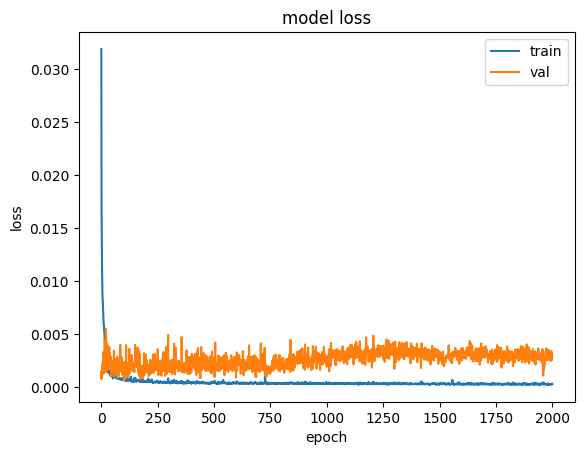

In [173]:
#Days in pattern into model
num_steps_in = 30
#Days in model output prediciton
num_steps_out= 30


#set prediction and input columns
inputColumns = ['case_Count']
outputColumn = "case_Count"

#Change first variable to run CNN, GRU, LSTM, or Hybrid Model
X_train, Y_train, model, history, best_hps= Modeler('CNN', df, inputColumns, outputColumn, num_steps_in, num_steps_out)


In [174]:
#predict the test set
pred_train = model.predict(X_train, verbose=2)


34/34 - 0s - 87ms/epoch - 3ms/step


In [175]:
#Display the optimal model parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 24, 16)            128       
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                19250     
                                                                 
 activation_3 (Activation)   (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 25)                1275      
                                                                 
 activation_4 (Activation)   (None, 25)                0         
                                                                 
 dense_6 (Dense)             (None, 75)               

In [176]:
#Print Root Mean Squared Error
print('RMSE = ', rmse(Y_train, pred_train).mean())

RMSE =  0.02310147205765108
